### Installing Packages

In [1]:
!pip install torchdata
!pip install -U torchtext==0.13.0
!pip install datasets
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.3 MB/s 
     |████████████████████████████████| 139 kB 56.1 MB/s 
     |████████████████████████████████| 776.3 MB 12 kB/s 
     |████████████████████████████████| 127 kB 52.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0+cu113
    Uninstalling torch-1.12.0+cu113:
      Successfully uninstalled torch-1.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.0+cu113 requires torch==1.12.0, but you have torch 1.12.1 which is incompatible.
torchtext 0.13.0 requires torch==1.12.0, but you have torch 1.12.1 wh

### Importing Packages

In [2]:
import torch
import torchtext
import datasets

import matplotlib.pyplot as plt
%matplotlib inline

import torch.optim as optim

### Using NLTK Library

I used the nltk package in order to remove stop words (i.e. any, then, etc) from the movie reviews.

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
from nltk.corpus import stopwords

stops = set(stopwords.words('english'))
print(stops)

{'t', 'shouldn', 'hers', 'while', 'between', 'now', "that'll", 'yourselves', 'the', "didn't", 'hasn', 'which', 'we', 'ma', 'further', 'so', 'more', "hadn't", 'that', 'into', "won't", 'it', "needn't", 'your', 'any', 'most', 'some', 'just', 'them', "should've", "doesn't", 'ourselves', "mustn't", 'me', 'doesn', 'below', 'but', 'too', 'does', "she's", 'then', 'of', 'll', 'having', 'or', 'shan', 'being', 'she', 'until', "shan't", 'you', 'here', 'ours', 'y', 'their', 'this', 'if', 'from', 'his', 'our', 'needn', 'about', 'wasn', "isn't", 'other', 'themselves', 'whom', 'didn', 'i', 'herself', "you're", 'all', 'himself', 'off', 'above', 'been', 'isn', 'at', 'doing', 'such', 'theirs', 'against', 'because', 'under', 'same', "you've", 'don', 'am', 'out', 'haven', 'a', 'few', 'those', 'only', 'wouldn', 'him', 'both', 'should', 'again', 'hadn', 'mustn', 'why', 'do', 'is', 'they', 'couldn', 'once', 'in', "aren't", 'an', "it's", 'will', 'aren', 'who', 'these', 'than', 'with', 'be', "hasn't", 'to', "do

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Hugging Face Dataset

I used the imdb dataset from the Hugging Face package. This dataset has 25,000 training examples and 25,000 test examples. I also shuffled the dataset because the original dataset has all negative movie reviews listed first and all positive movie reviews listed last, so I wanted to randomize the data for training.

In [6]:
# get dataset from hugging face library
train_data, test_data = datasets.load_dataset('imdb', split = ['train', 'test'])

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
# reshuffle training and test datasets (randomize)
train_data = train_data.shuffle()
test_data = test_data.shuffle()

In [8]:
train_data[:10]

{'label': [0, 1, 1, 1, 1, 0, 1, 0, 1, 0],
 'text': ["Kirstie Alley, looking a bit slimmer, but only a bit, is in this mess along with a man who is a MacGuyver lookalike, bleached blond hair and all. The premise of the movie is about an older woman (50!!!) who cannot get her screenplay produced due to age discrimination so she sends in her younger nephew to pose as the writer. Not an original idea and not a very good movie with lousy acting, inane dialogue and a ridiculous plot. There is another plot concerning a writer with a crush or admiration for Kirstie's character and why this is included is a mystery. The actor who portrays Kirstie's brother is so wooden and miscast, it was torture to watch their scenes. What is there to say about this film. Avoid it.",
  "just watched it on sky TV missed the first half an hour. i did wonder if it was a true story so watched it to the end. there was no brief at the end to say what happened to everyone. it did remind me of speed but at the end of 

### Pre-Processing Data

I first removed stop words from the reviews and then tokenized this data. I then used this tokenized data to create a vocab (with tokens that have min_freq=50). I then created a vector of vocab indexes for the tokens for each review.

In [9]:
from torchtext.data.utils import get_tokenizer

# use a standard english tokenizer
tokenizer = get_tokenizer('basic_english')

# function that tokenizes the data and removes stopwords
def tokenize_data(ex):
    stop_words = set(stopwords.words('english'))
    tokens = tokenizer(ex['text'])
    tokens_without_stopwords = [token for token in tokens if token not in stop_words]
    return {'tokens': tokens_without_stopwords}

train_data = train_data.map(tokenize_data)
test_data = test_data.map(tokenize_data)

  0%|          | 0/25000 [00:00<?, ?ex/s]

  0%|          | 0/25000 [00:00<?, ?ex/s]

In [10]:
train_data, test_data

(Dataset({
     features: ['text', 'label', 'tokens'],
     num_rows: 25000
 }), Dataset({
     features: ['text', 'label', 'tokens'],
     num_rows: 25000
 }))

In [11]:
#Documentation: https://huggingface.co/docs/datasets/v2.4.0/en/package_reference/main_classes#datasets.Dataset.train_test_split
# split the training data into training and validation data
train_valid_data = train_data.train_test_split() # default test_size is 0.25
train_data = train_valid_data['train']
valid_data = train_valid_data['test']

In [12]:
train_data, valid_data, test_data

(Dataset({
     features: ['text', 'label', 'tokens'],
     num_rows: 18750
 }), Dataset({
     features: ['text', 'label', 'tokens'],
     num_rows: 6250
 }), Dataset({
     features: ['text', 'label', 'tokens'],
     num_rows: 25000
 }))

In [13]:
from torchtext.vocab import Vocab, build_vocab_from_iterator

UNK_IDX, PAD_IDX = 0, 1
special_symbols = ['<unk>', '<pad>']

# build vocab from the text tokens from training data
vocab = build_vocab_from_iterator(train_data['tokens'], min_freq = 50, specials = special_symbols)
#vocab = build_vocab_from_iterator(train_data['tokens'], max_tokens = 32, specials = special_symbols)

# set unknown index as the default
vocab.set_default_index(UNK_IDX)

len(vocab)

5732

In [ ]:
ls

drive/  LSTM_vocab.pth  sample_data/


In [14]:
# save the vocab object
torch.save(vocab, 'GRU_vocab.pth')

In [15]:
# transform the tokens into numerical values 
def transform_tokens_idxs(ex):
  idxs = {'idxs': [vocab[token] for token in ex['tokens']]}
  return idxs

# add a column with the idxs
train_data = train_data.map(transform_tokens_idxs)
valid_data = valid_data.map(transform_tokens_idxs)
test_data = test_data.map(transform_tokens_idxs)

  0%|          | 0/18750 [00:00<?, ?ex/s]

  0%|          | 0/6250 [00:00<?, ?ex/s]

  0%|          | 0/25000 [00:00<?, ?ex/s]

In [16]:
train_data, valid_data, test_data

(Dataset({
     features: ['text', 'label', 'tokens', 'idxs'],
     num_rows: 18750
 }), Dataset({
     features: ['text', 'label', 'tokens', 'idxs'],
     num_rows: 6250
 }), Dataset({
     features: ['text', 'label', 'tokens', 'idxs'],
     num_rows: 25000
 }))

### Collate into Batches

This will be the collate function to group the data into batches for the dataloader. 

In [28]:
from torch.nn.utils.rnn import pad_sequence

# collate function to put examples in batches 
def collate_batch(batch):
  batch_idxs, batch_labels = [], []

  for b in batch: 
    #print(b)
    batch_idxs.append(torch.LongTensor(b['idxs']))
    batch_labels.append(torch.tensor(b['label']))

  # pad idxs that are shorter than the longest sentence
  batch_idxs = pad_sequence(batch_idxs, batch_first = False, padding_value = PAD_IDX)
  batch_labels = torch.stack(batch_labels)

  batch = {'idxs': batch_idxs,
           'labels': batch_labels}
  
  return batch

### Training an Epoch

This is the basic training model where the indices are passed into the model and the gradients and weights are changed each iteration. Training is done with the Adam optimization algorithm, which is an extension to SGD.

In [29]:
def get_accuracy(predictions, actual_labels):
    batch_size = predictions.shape[0]
    predicted_labels = predictions.argmax(1)
    num_correct = (predicted_labels == actual_labels).sum()
    accuracy = num_correct / batch_size
    return accuracy

In [30]:
GRAD_CLIP = 1

def train(dataloader, model, optimizer, criterion):
    model.train()

    epoch_loss, epoch_accuracy = 0, 0

    for idx, batch in enumerate(dataloader):
        token_ids = batch['idxs'].to(device)
        labels = batch['labels'].to(device)
        model.zero_grad()
        predictions = model(token_ids)
        loss = criterion(predictions, labels)
        accuracy = get_accuracy(predictions, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()
        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()

    return epoch_loss / len(dataloader), epoch_accuracy / len(dataloader)

In [31]:
def evaluate(dataloader, model, criterion):
    model.eval()

    epoch_loss, epoch_accuracy = 0, 0

    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            token_ids = batch['idxs'].to(device)
            labels = batch['labels'].to(device)
            predictions = model(token_ids)
            loss = criterion(predictions, labels)
            accuracy = get_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_accuracy += accuracy.item()

    return epoch_loss / len(dataloader), epoch_accuracy / len(dataloader)

In [32]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### GRU

$$
h_t = \text{GRU}(E_{[x_t]}), \\
u_t = \text{dropout}(h_t), \\
scores = \text{Linear}(u_t)
$$


In [33]:
# SIMPLE GRU MODEL
from torch import nn

class RNN(nn.Module):
# I referred to this tutorial for help: https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb
    def __init__(self, vocab_size, emb_dim, hid_dim, output_dim, dropout = 0.5):
        super().__init__()
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        # RNN layer
        self.rnn = nn.GRU(emb_dim, hid_dim) # default batch_first is False
        # dropout
        self.dropout = nn.Dropout(dropout)
        # linear layer 
        self.linear1 = nn.Linear(hid_dim, output_dim)
    def forward(self, text):
        # input text is dimension [seq_len, batch_size]
        # apply embeddings to the words
        #print('text input shape')
        #print(text.shape)
        #lengths = text[0,:]
        #print('lengths')
        #print(lengths)
        seq_len = text.shape[0]
        batch_size = text.shape[1]
        embedded = self.embedding(text)
        #print('embedded shape')
        #print(embedded.shape)
        # embedded is dimension [seq_len, batch_size, emb_dim] because batch_first = False
        # run through RNN
        output, hidden = self.rnn(embedded)
        # hidden[0] is dimension [1, batch_size, hid_dim]
        # get the predictions
        #print('hidden dim')
        #print(hidden[0].shape)
        #print('output before linear (after lstm)')
        #print(output.shape)
        last_output = output[-1]
        last_output = self.dropout(last_output)
        scores = self.linear1(last_output) 
        #print('output after linear')
        #print(output.shape)
        # scores should have the dimension [batch_size, output_dim]
        return scores

### Fine Tuning GRU Parameters

I tinkered with the parameters and put a comment at the top of the cell of the parameters I was testing out. The final GRU model with the final parameters chosen is shown at the very bottom of this notebook. 

In [23]:
# with grad clipping and dropout = 0.10

from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)

INPUT_DIM = len(vocab)
EMBEDDING_DIM = 32
HIDDEN_DIM = 128
OUTPUT_DIM = 2 # there are only 2 labels - 0 (neg) or 1 (pos)
DROPOUT = 0.10

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
        
model.apply(init_weights)

# initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-3)

# RNN (with vocab min freq = 50 and all examples)
N_EPOCHS = 30
best_valid_loss = float('inf')

valid_accuracies = []
train_accuracies = []
test_accuracies = []
train_losses = []

for epoch in range(N_EPOCHS):
  
    start_time = time.time()

    train_loss, train_acc = train(train_dataloader, model, optimizer, criterion)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion)
    test_loss, test_acc = evaluate(test_dataloader, model, criterion)

    end_time = time.time()

    valid_accuracies.append(valid_acc)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    train_losses.append(train_loss)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'GRU-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}')
    print(f'valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}')
    print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')

plt.title('GRU for Full Review')
plt.plot(range(1, N_EPOCHS+1), valid_accuracies, label = 'validation accuracy')
plt.plot(range(1, N_EPOCHS+1), train_accuracies, label = 'training accuracy')
plt.plot(range(1, N_EPOCHS+1), test_accuracies, label = 'test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")

Epoch: 01 | Time: 0m 49s
train_loss: 0.695, train_acc: 0.500
valid_loss: 0.694, valid_acc: 0.505
test_loss: 0.694, test_acc: 0.502
Epoch: 02 | Time: 0m 49s
train_loss: 0.621, train_acc: 0.644
valid_loss: 0.398, valid_acc: 0.819
test_loss: 0.402, test_acc: 0.817
Epoch: 03 | Time: 0m 49s
train_loss: 0.333, train_acc: 0.860
valid_loss: 0.328, valid_acc: 0.862
test_loss: 0.340, test_acc: 0.856
Epoch: 04 | Time: 0m 49s
train_loss: 0.257, train_acc: 0.899
valid_loss: 0.402, valid_acc: 0.838
test_loss: 0.413, test_acc: 0.835
Epoch: 05 | Time: 0m 49s
train_loss: 0.224, train_acc: 0.913
valid_loss: 0.375, valid_acc: 0.856
test_loss: 0.384, test_acc: 0.850
Epoch: 06 | Time: 0m 50s
train_loss: 0.204, train_acc: 0.924
valid_loss: 0.448, valid_acc: 0.839
test_loss: 0.467, test_acc: 0.834
Epoch: 07 | Time: 0m 49s
train_loss: 0.191, train_acc: 0.925
valid_loss: 0.465, valid_acc: 0.848
test_loss: 0.488, test_acc: 0.840
Epoch: 08 | Time: 0m 49s
train_loss: 0.207, train_acc: 0.920
valid_loss: 0.433, val

KeyboardInterrupt: ignored

In [24]:
# with grad clipping and dropout = 0.25

from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)

INPUT_DIM = len(vocab)
EMBEDDING_DIM = 32
HIDDEN_DIM = 128
OUTPUT_DIM = 2 # there are only 2 labels - 0 (neg) or 1 (pos)
DROPOUT = 0.25

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
        
model.apply(init_weights)

# initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-3)

# RNN (with vocab min freq = 50 and all examples)
N_EPOCHS = 30
best_valid_loss = float('inf')

valid_accuracies = []
train_accuracies = []
test_accuracies = []
train_losses = []

for epoch in range(N_EPOCHS):
  
    start_time = time.time()

    train_loss, train_acc = train(train_dataloader, model, optimizer, criterion)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion)
    test_loss, test_acc = evaluate(test_dataloader, model, criterion)

    end_time = time.time()

    valid_accuracies.append(valid_acc)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    train_losses.append(train_loss)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'GRU-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}')
    print(f'valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}')
    print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')

plt.title('GRU for Full Review')
plt.plot(range(1, N_EPOCHS+1), valid_accuracies, label = 'validation accuracy')
plt.plot(range(1, N_EPOCHS+1), train_accuracies, label = 'training accuracy')
plt.plot(range(1, N_EPOCHS+1), test_accuracies, label = 'test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")

Epoch: 01 | Time: 0m 49s
train_loss: 0.661, train_acc: 0.603
valid_loss: 0.458, valid_acc: 0.787
test_loss: 0.475, test_acc: 0.776
Epoch: 02 | Time: 0m 49s
train_loss: 0.382, train_acc: 0.840
valid_loss: 0.386, valid_acc: 0.831
test_loss: 0.397, test_acc: 0.826
Epoch: 03 | Time: 0m 49s
train_loss: 0.279, train_acc: 0.888
valid_loss: 0.324, valid_acc: 0.864
test_loss: 0.345, test_acc: 0.855
Epoch: 04 | Time: 0m 50s
train_loss: 0.233, train_acc: 0.911
valid_loss: 0.420, valid_acc: 0.840
test_loss: 0.439, test_acc: 0.831
Epoch: 05 | Time: 0m 50s
train_loss: 0.205, train_acc: 0.924
valid_loss: 0.430, valid_acc: 0.856
test_loss: 0.455, test_acc: 0.846
Epoch: 06 | Time: 0m 50s
train_loss: 0.185, train_acc: 0.936
valid_loss: 0.356, valid_acc: 0.855
test_loss: 0.375, test_acc: 0.849
Epoch: 07 | Time: 0m 50s
train_loss: 0.184, train_acc: 0.935
valid_loss: 0.392, valid_acc: 0.860
test_loss: 0.428, test_acc: 0.849
Epoch: 08 | Time: 0m 50s
train_loss: 0.196, train_acc: 0.928
valid_loss: 0.437, val

KeyboardInterrupt: ignored

In [34]:
# with grad clipping and dropout = 0.1

from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)

INPUT_DIM = len(vocab)
EMBEDDING_DIM = 32
HIDDEN_DIM = 128
OUTPUT_DIM = 2 # there are only 2 labels - 0 (neg) or 1 (pos)
DROPOUT = 0.1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
        
model.apply(init_weights)

# initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-3)

# RNN (with vocab min freq = 50 and all examples)
N_EPOCHS = 10
best_valid_loss = float('inf')

valid_accuracies = []
train_accuracies = []
test_accuracies = []
train_losses = []

for epoch in range(N_EPOCHS):
  
    start_time = time.time()

    train_loss, train_acc = train(train_dataloader, model, optimizer, criterion)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion)
    test_loss, test_acc = evaluate(test_dataloader, model, criterion)

    end_time = time.time()

    valid_accuracies.append(valid_acc)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    train_losses.append(train_loss)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'GRU-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}')
    print(f'valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}')
    print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')

plt.title('GRU for Full Review')
plt.plot(range(1, N_EPOCHS+1), valid_accuracies, label = 'validation accuracy')
plt.plot(range(1, N_EPOCHS+1), train_accuracies, label = 'training accuracy')
plt.plot(range(1, N_EPOCHS+1), test_accuracies, label = 'test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")

Epoch: 01 | Time: 0m 49s
train_loss: nan, train_acc: 0.499
valid_loss: nan, valid_acc: 0.494
test_loss: nan, test_acc: 0.500


KeyboardInterrupt: ignored

### Final GRU Model

After tinkering with parameters, I settled on the following parameters as the final GRU Model.

Epoch: 01 | Time: 0m 49s
train_loss: 0.707, train_acc: 0.500
valid_loss: 0.690, valid_acc: 0.532
test_loss: 0.693, test_acc: 0.530
Epoch: 02 | Time: 0m 49s
train_loss: 0.539, train_acc: 0.728
valid_loss: 0.370, valid_acc: 0.839
test_loss: 0.382, test_acc: 0.828
Epoch: 03 | Time: 0m 49s
train_loss: 0.341, train_acc: 0.860
valid_loss: 0.331, valid_acc: 0.855
test_loss: 0.345, test_acc: 0.849
Epoch: 04 | Time: 0m 49s
train_loss: 0.273, train_acc: 0.893
valid_loss: 0.330, valid_acc: 0.863
test_loss: 0.347, test_acc: 0.853
Epoch: 05 | Time: 0m 49s
train_loss: 0.229, train_acc: 0.913
valid_loss: 0.396, valid_acc: 0.854
test_loss: 0.408, test_acc: 0.846
Epoch: 06 | Time: 0m 49s
train_loss: 0.200, train_acc: 0.927
valid_loss: 0.433, valid_acc: 0.842
test_loss: 0.458, test_acc: 0.833
Epoch: 07 | Time: 0m 49s
train_loss: 0.173, train_acc: 0.938
valid_loss: 0.429, valid_acc: 0.851
test_loss: 0.437, test_acc: 0.846
Epoch: 08 | Time: 0m 48s
train_loss: 0.169, train_acc: 0.940
valid_loss: 0.452, val

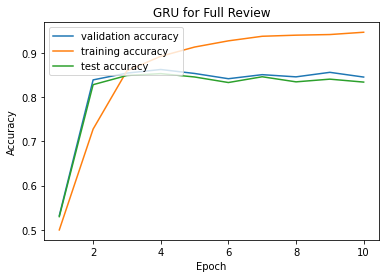

In [35]:
# with grad clipping and dropout = 0.50

from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)

INPUT_DIM = len(vocab)
EMBEDDING_DIM = 32
HIDDEN_DIM = 128
OUTPUT_DIM = 2 # there are only 2 labels - 0 (neg) or 1 (pos)
DROPOUT = 0.25

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
        
model.apply(init_weights)

# initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-3)

# RNN (with vocab min freq = 50 and all examples)
N_EPOCHS = 10
best_valid_loss = float('inf')

valid_accuracies = []
train_accuracies = []
test_accuracies = []
train_losses = []

for epoch in range(N_EPOCHS):
  
    start_time = time.time()

    train_loss, train_acc = train(train_dataloader, model, optimizer, criterion)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion)
    test_loss, test_acc = evaluate(test_dataloader, model, criterion)

    end_time = time.time()

    valid_accuracies.append(valid_acc)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    train_losses.append(train_loss)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'GRU-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}')
    print(f'valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}')
    print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')

plt.title('GRU for Full Review')
plt.plot(range(1, N_EPOCHS+1), valid_accuracies, label = 'validation accuracy')
plt.plot(range(1, N_EPOCHS+1), train_accuracies, label = 'training accuracy')
plt.plot(range(1, N_EPOCHS+1), test_accuracies, label = 'test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")

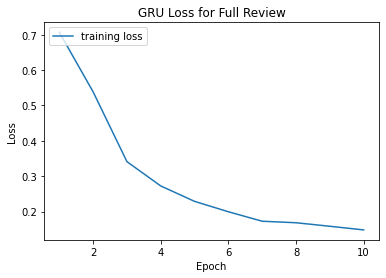

In [36]:
plt.title('GRU Loss for Full Review')
plt.plot(range(1, N_EPOCHS+1), train_losses, label = 'training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper left")

In [38]:
model.load_state_dict(torch.load('GRU-model.pt'))
test_loss, test_acc = evaluate(test_dataloader, model, criterion)
print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')

test_loss: 0.347, test_acc: 0.853


In [41]:
model.load_state_dict(torch.load('GRU-model.pt'))
test_loss, test_acc = evaluate(test_dataloader, model, criterion)
print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')

test_loss: 0.347, test_acc: 0.853


### Predictions

In [39]:
model.load_state_dict(torch.load('GRU-model.pt'))

def predict_label(text):
  labels = ['Negative', 'Positive']

  # put model in eval mode
  model.eval()

  # process input
  stop_words = set(stopwords.words('english'))
  tokens = tokenizer(text)
  tokens_without_stopwords = [token for token in tokens if token not in stop_words]
  idxs = [vocab[token] for token in tokens_without_stopwords]
  idxs = torch.tensor(idxs).to(device)
  # add batch of 1 (dimension)
  idxs = idxs.unsqueeze(1)

  with torch.no_grad():
    scores = model(idxs)

  predicted_label = scores.argmax(1)

  return labels[predicted_label.item()]
  

In [43]:
text_review = 'This movie was the worst'
l = predict_label(text_review)
print(l)

Negative


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data
